# Redes Neuronales Artificiales (ANN) vs. Redes Neuronales Informadas por la Física

By Tabita Catalán, Tomás Banduc, David Ortiz y Francisco Sahli, 2025

Accede al trabajo fundacional de las PINNs [aquí](https://www.sciencedirect.com/science/article/pii/S0021999118307125).

### Introducción

Las Redes Neuronales Artificiales (ANNs) son herramientas potentes para resolver tareas complejas basadas en datos. Sin embargo, suelen necesitar grandes volúmenes de datos y pueden carecer de interpretabilidad al aplicarse a sistemas físicos. Las Redes Neuronales Informadas por la Física (PINNs) enfrentan este desafío integrando leyes físicas conocidas directamente en el proceso de entrenamiento, lo que las hace especialmente útiles cuando se dispone de ecuaciones gobernantes pero los datos son limitados. En esta actividad, exploraremos ambos enfoques aplicándolos al modelado del **péndulo oscilante**, un sistema clásico no lineal.  

### Resumen de la Actividad

En esta actividad, programaremos una Red Neuronal Artificial (ANN) y una Red Neuronal Informada por la Física (PINN) para resolver el modelo matemático no lineal de un **péndulo oscilante**. Este enfoque resaltará los beneficios de integrar las leyes físicas en la función de pérdida de la red.

### Objetivos de la Actividad

Al finalizar esta actividad, podrás:

- Comprender la necesidad de soluciones numéricas en modelos complejos.  
- Reconocer las ventajas de las Redes Neuronales Informadas por la Física (PINNs) sobre las Redes Neuronales Artificiales (ANNs) tradicionales.  
- Utilizar PyTorch para entrenar PINNs, integrando datos con la física del modelo.
- Aplicar PINNs para resolver modelos no lineales.  

## Modelo matemático para describir un péndulo oscilante

Queremos resolver el problema matemático relacionado con el **péndulo oscilante** [(wiki)](https://en.wikipedia.org/wiki/Pendulum_(mechanics)):

| ![GIF](../data/figures/Oscillating_pendulum.gif?raw=1) | <img src="../data/figures/Pendulum_gravity.svg?raw=1" alt="Diagrama del proyecto" width="300"/> |
|-------------------------------------------|-------------------------------------------|
| Vectores de velocidad y aceleración del péndulo  | Diagrama de fuerzas |


**Supuestos:**

- La varilla es rígida y sin masa [(Tarea - el caso de una cuerda elástica)](https://en.wikipedia.org/wiki/Elastic_pendulum#:~:text=In%20physics%20and%20mathematics%2C%20in,%2Ddimensional%20spring%2Dmass%20system.).
- El peso es una masa puntual.  
- Dos dimensiones [(Tarea - una dimensión adicional de movimiento)](https://www.instagram.com/reel/CffUr64PjCx/?igsh=MWlmM2FscG9oYnp6bw%3D%3D).
- No hay resistencia del aire [(Tarea - inmersión en un fluido)](https://www.youtube.com/watch?v=erveOJD_qv4&ab_channel=Lettherebemath).
- El campo gravitacional es uniforme y el soporte no se mueve.

Nos interesa encontrar el ángulo vertical $\theta(t) \in [0, 2\pi)$ tal que:

$$
\frac{d^2\theta}{dt^2}+\frac{g}{l}\sin\theta=0,\quad\theta(0)=\theta_0,\quad\theta'(0)=0,\quad t\in\mathbb{R},
$$

donde $g\approx 9.81[m/s^2]$, $l$ es el largo de la varilla y $t$ la variable temporal.  

**Repaso de conceptos de ecuaciones diferenciales:**

- ¿Por qué esta es una ecuación diferencial no lineal? ¿Qué supuestos deberían hacerse para linealizar el modelo?
- ¿Es una ecuación diferencial ordinaria (EDO) o una ecuación diferencial parcial (EDP)?  
- ¿Cuál es el orden? ¿cuál es el grado?  

Un método útil es convertir el modelo en un sistema acoplado de EDOs:  

$$
\begin{align*}
\frac{d\theta}{dt} &= \omega, \quad \text{(velocidad angular)}\\
\frac{d\omega}{dt} & = -\frac{g}{l}\sin\theta, \quad \text{(aceleración angular)}
\end{align*}
$$

### Flujo de Trabajo  
1. Calcular la solución numérica del modelo no lineal del péndulo oscilante.  
2. Preparar los datos de entrenamiento añadiendo ruido, remuestreando y limitando el tiempo para simular un escenario real.  
3. Definir el modelo ANN utilizando la arquitectura de PyTorch y entrenar con los datos preparados. Graficar la solución.  
4. Definir el modelo PINN utilizando la arquitectura de PyTorch y entrenar con los datos preparados. Graficar la solución.  
5. Comparar las soluciones obtenidas con ambas arquitecturas. 

## Configuración Inicial  

Comenzamos importando algunos paquetes útiles y definiendo algunas funciones.

In [16]:
%matplotlib inline

In [17]:
# Import NumPy for numerical operations
import numpy as np
# Import PyTorch for building and training neural networks
import torch
import torch.nn as nn
import torch.optim as optim
# Import Matplotlib for plotting
import matplotlib.pyplot as plt
import matplotlib as mlp
# Import the time module to time our training process
import time
# Ignore Warning Messages
import warnings
warnings.filterwarnings("ignore")

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Actualización de los parámetros de Matplotlib
gray = '#5c5c5c' #'#5c5c5c' '000'
mlp.rcParams.update(
    {
        "image.cmap" : 'viridis', # plasma, inferno, magma, cividis
        "text.color" : gray,
        "xtick.color" :gray,
        "ytick.color" :gray,
        "axes.labelcolor" : gray,
        "axes.edgecolor" :gray,
        "axes.spines.right" : False,
        "axes.spines.top" : False,
        "axes.formatter.use_mathtext": True,
        "axes.unicode_minus": False,

        'font.size' : 15,
        'interactive': False,
        "font.family": 'sans-serif',
        "legend.loc" : 'best',
        'text.usetex': False,
        'mathtext.fontset': 'stix',
    }
)

# Util function to calculate the signal-to-noise ratio
def calculate_snr(signal, noise):
    # Ensure numpy arrays
    signal, noise = np.array(signal), np.array(noise)

    # Calculate the power of the signal and the noise
    signal_power = np.mean(signal**2)
    noise_power = np.mean(noise**2)

    # Calculate the SNR in decibels (dB)
    snr = 10 * np.log10(signal_power / noise_power)
    return snr

# Util function to calculate the relative l2 error
def relative_l2_error(u_num, u_ref):
    # Calculate the L2 norm of the difference
    l2_diff = torch.norm(u_num - u_ref, p=2)

    # Calculate the L2 norm of the reference
    l2_ref = torch.norm(u_ref, p=2)

    # Calculate L2 relative error
    relative_l2 = l2_diff / l2_ref
    return relative_l2

# Util function to plot the solutions
def plot_comparison(time, theta_true, theta_pred, loss):

    # Convert tensors to numpy arrays for plotting
    t_np = time.detach().cpu().data.numpy()
    theta_pred_np = theta_pred.detach().cpu().data.numpy()

    # Create a figure with 2 subplots
    _, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Plot the true and predicted values
    axs[0].plot(t_np, theta_true, label = r'$\theta(t)$ (numerical solution)')
    axs[0].plot(t_np, theta_pred_np, label = r'$\theta_{pred}(t)$ (predicted solution) ')
    axs[0].set_title('Angular displacement Numerical Vs. Predicted')
    axs[0].set_xlabel(r'Time $(s)$')
    axs[0].set_ylabel('Amplitude')
    axs[0].set_ylim(-1,1.3)
    axs[0].legend(loc='best', frameon=False)


    # Plot the difference between the predicted and true values
    difference = np.abs(theta_true.reshape(-1,1) - theta_pred_np.reshape(-1,1))
    axs[1].plot(t_np, difference)
    axs[1].set_title('Absolute Difference')
    axs[1].set_xlabel(r'Time $(s)$')
    axs[1].set_ylabel(r'$|\theta(t) - \theta_{pred}(t)|$')
    # Display the plot
    plt.legend(loc='best', frameon=False)
    plt.tight_layout()
    plt.show()

    # Plot the loss values recorded during training
    # Create a figure with 1 subplots
    _, axs = plt.subplots(1, 1, figsize=(6, 3))
    axs.plot(loss)
    axs.set_xlabel('Iteration')
    axs.set_ylabel('Loss')
    axs.set_yscale('log')
    axs.set_xscale('log')
    axs.set_title('Training Progress')
    axs.grid(True)

    # Display the plot
    plt.tight_layout()
    plt.show()

# Util function to calculate tensor gradients with autodiff
def grad(outputs, inputs):
    """Computes the partial derivative of an output with respect
    to an input.
    Args:
        outputs: (N, 1) tensor
        inputs: (N, D) tensor
    """
    return torch.autograd.grad(outputs, inputs,
                        grad_outputs=torch.ones_like(outputs),
                        create_graph=True,
                        )[0]

Using cuda device


## 1. Solución numérica del péndulo oscilante  
Para la solución numérica utilizamos el método [Runge-Kutta de cuarto orden](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods) de `scipy`. Comenzamos definiendo los parámetros para este ejemplo, el modelo del péndulo y el dominio:  

In [18]:
g = 9.81  # gravity acceleration (m/s^2)
L = 1.0   # Pendulum's rod length (m)
theta0 = np.pi / 4  # Initial condition (Position in rads)
omega0 = 0.0        # Initial angular speed (rad/s)
sample_freq = 100   # sample rate 100Hz

# Simulation time
t_span = (0, 10)  # from 0 to 10 seconds
t_eval = np.linspace(t_span[0], t_span[1], sample_freq*t_span[1])  # Points to be evaluated

# We define the system of coupled ODEs
def pendulum(t, y):
    theta, omega = y
    dtheta_dt = omega
    domega_dt = -(g / L) * np.sin(theta)
    return [dtheta_dt, domega_dt]

# Initial conditions
y0 = [theta0, omega0]

Ahora resolvemos el problema numéricamente utilizando `scipy`.

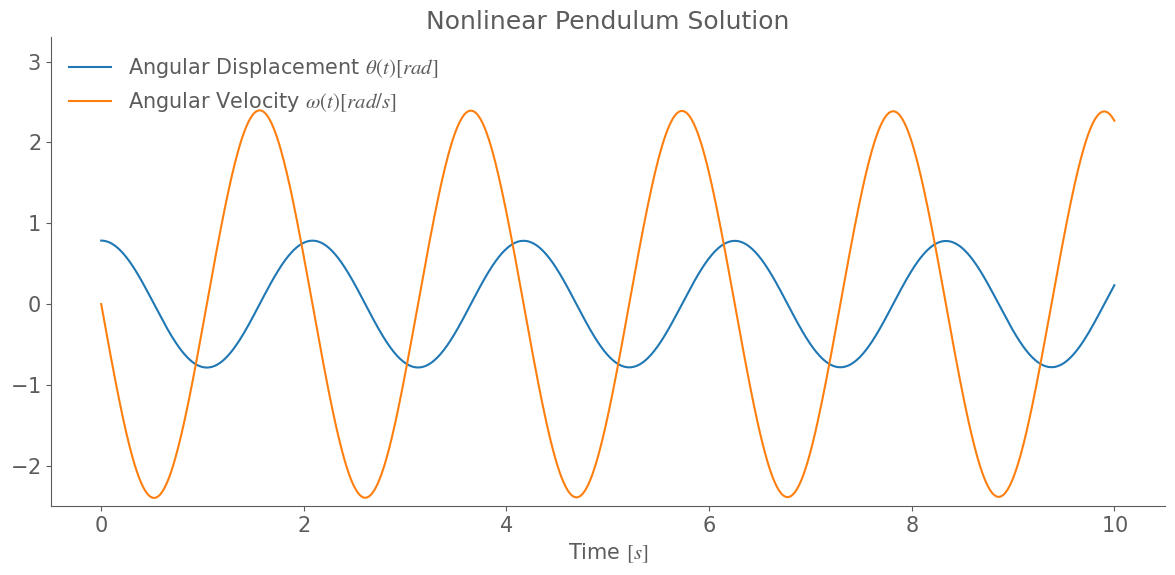

In [19]:
from scipy.integrate import solve_ivp

# Solve the initial value problem using Runge-Kutta 4th order
num_sol = solve_ivp(pendulum, t_span, y0, t_eval=t_eval, method='RK45')

# We extract the solutions
theta_num = num_sol.y[0]
omega_num = num_sol.y[1]

# We graph the results
plt.figure(figsize=(12, 6))
plt.plot(t_eval, theta_num, label=r'Angular Displacement $\theta(t)[rad]$')
plt.plot(t_eval, omega_num, label=r'Angular Velocity $\omega(t)[rad/s]$')
plt.xlabel(r'Time $[s]$')
plt.ylim(-2.5,3.3)
plt.legend(loc='best', frameon=False)
plt.title('Nonlinear Pendulum Solution')
plt.grid(False)
plt.tight_layout()
plt.show()

## 2. Preparación de los datos de entrenamiento  <a id='data_prep'></a>

A continuación, consideramos la solución numérica como los **datos de entrenamiento** que provienen de las mediciones de un sensor. Añadimos ruido gaussiano, remuestreamos y recortamos los datos a $2.5$ s para evaluar el rendimiento de la ANN, simulando un escenario real. Además, calculamos la relación señal-ruido $SNR = 10\log_{10} \left(\frac{P_{signal}}{P_{noise}}\right)$, donde $P_{signal}$ y $P_{noise}$ son la potencia de la señal y del ruido, respectivamente, para determinar el nivel de distorsión en la señal. Finalmente, llamamos a los datos de entrenamiento con ruido $\theta_{data}(t)$.  


SNR: 21.1630 dB


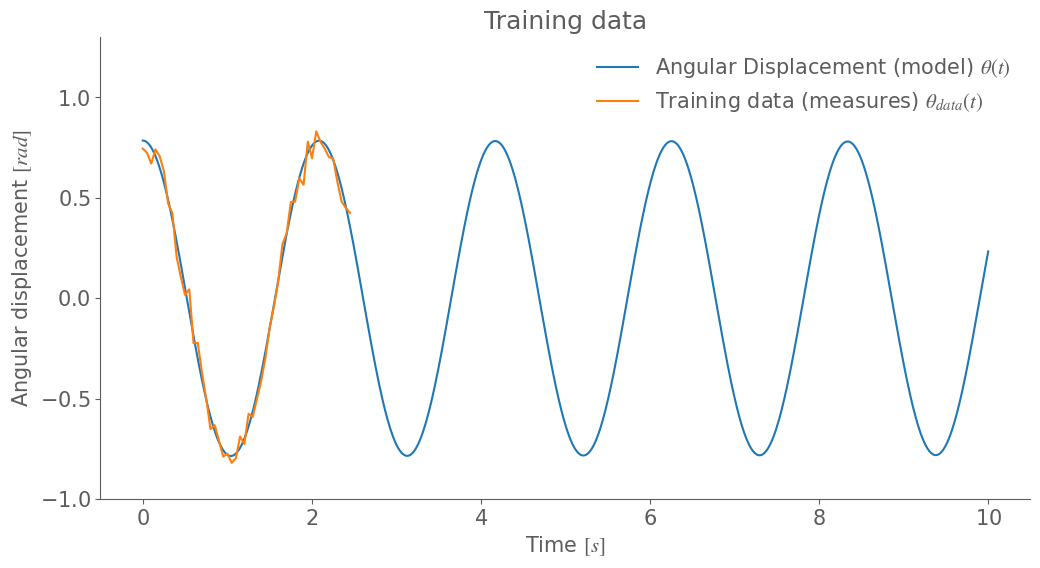

In [20]:
# Add gaussian noise
std_deviation = 0.05
noise = np.random.normal(0,std_deviation,theta_num.shape[0])
theta_noisy = theta_num + noise
print(f'SNR: {calculate_snr(theta_noisy, noise):.4f} dB')

# Resample and cut to 2.5s
resample = 5          # resample
cut_time = int(2.5*sample_freq)  # 2.5s times 100Hz

theta_data = theta_noisy[:cut_time:resample]
t_data = t_eval[:cut_time:resample]

# We graph the observed data
plt.figure(figsize=(12, 6))
plt.plot(t_eval, theta_num, label=r'Angular Displacement (model) $\theta(t)$ ')
plt.plot(t_data, theta_data, label=r'Training data (measures) $\theta_{data}(t)$ ')
plt.xlabel(r'Time $[s]$')
plt.ylabel(r'Angular displacement $[rad]$')
plt.ylim(-1,1.3)
plt.legend(loc='best', frameon=False)
plt.title('Training data')
plt.grid(False)
plt.show()

## 3. Entrenando la Red Neuronal Artificial

Entrenaremos la red neuronal artificial para aproximar directamente la solución de la ecuación diferencial, es decir,

$$
\theta_{NN}(t; \Theta) \approx \theta(t)
$$

donde $\Theta$ son los parámetros entrenables de la ANN. Utilizaremos `PyTorch` para definir la red y la entrenaremos con el optimizador ADAM. Además, convertiremos el dominio temporal y las observaciones a `torch.tensors`. 

In [21]:
torch.manual_seed(123)

# training parameters
hidden_layers = [1, 50, 50, 50, 1]
learning_rate = 0.001
training_iter = 50000

In [22]:
# Define a loss function (Mean Squared Error) for training the network
MSE_func = nn.MSELoss()

# Convert the NumPy arrays to PyTorch tensors and add an extra dimension
# test time Numpy array to Pytorch tensor
t_test = torch.tensor(t_eval, device=device, requires_grad=True).view(-1,1).float()
# train time Numpy array to Pytorch tensor
t_data = torch.tensor(t_data, device=device, requires_grad=True).view(-1,1).float()
# Numerical theta to test Numpy array to pytorch tensor
theta_test = torch.tensor(theta_num, device=device, requires_grad=True).view(-1,1).float()
# Numerical theta to train Numpy array to pytorch tensor
theta_data = torch.tensor(theta_data, device=device, requires_grad=True).view(-1,1).float()

# Define a neural network class with user defined layers and neurons
class NeuralNetwork(nn.Module):

    def __init__(self, hlayers):
        super(NeuralNetwork, self).__init__()

        layers = []
        for i in range(len(hlayers[:-2])):
            layers.append(nn.Linear(hlayers[i], hlayers[i+1]))
            layers.append(nn.Tanh())
        layers.append(nn.Linear(hlayers[-2], hlayers[-1]))

        self.layers = nn.Sequential(*layers)
        self.init_params()

    def init_params(self):
        """Xavier Glorot parameter initialization of the Neural Network
        """
        def init_normal(m):
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight) # Xavier
        self.apply(init_normal)

    def forward(self, x):
        return self.layers(x)


In [23]:
# Create an instance of the neural network
theta_ann = NeuralNetwork(hidden_layers).to(device)
nparams = sum(p.numel() for p in theta_ann.parameters() if p.requires_grad)
print(f'Number of trainable parameters: {nparams}')

# Define an optimizer (Adam) for training the network
optimizer = optim.Adam(theta_ann.parameters(), lr=learning_rate,
                       betas= (0.99,0.999), eps = 1e-8)

Number of trainable parameters: 5251


### Función de pérdida 

Para entrenar la ANN necesitamos datos y una función de pérdida. Nuestros datos serán observaciones ruidosas de la solución $\theta_{data}(t)$, obtenidas en puntos de colocación $\{t_i\}_N$ elegidos del dominio. Utilizamos como función de pérdida el error cuadrático medio ($MSE$) entre estas observaciones y la evaluación de la ANN en los mismos puntos de colocación, es decir,

$$
\mathcal{L}(\Theta) := \lambda_1 MSE(\theta_{NN}(t; \Theta), \theta_{data}(t)) = \frac{\lambda_1}{N}\sum_i (\theta_{NN}(t_i; \Theta) - \theta_{data}(t_i))^2
$$

donde $\lambda_1 \in \mathbb{R}^+$ es un peso positivo y $N$ es el número de muestras. El entrenamiento se realiza minimizando la función de pérdida $\mathcal{L}(\Theta)$, es decir,

$$
\min_{\Theta \in \mathbb{R}} \mathcal{L}(\Theta) \rightarrow 0
$$

In [24]:
def NeuralNetworkLoss(forward_pass, t, theta_data, lambda1 = 1):

    theta_nn = forward_pass(t)
    data_loss = lambda1 * MSE_func(theta_nn, theta_data)

    return  data_loss

# Initialize a list to store the loss values
loss_values_ann = []

# Start the timer
start_time = time.time()

# Training the neural network
for i in range(training_iter):

    optimizer.zero_grad()   # clear gradients for next train

    # input x and predict based on x
    loss = NeuralNetworkLoss(theta_ann,
                             t_data,
                             theta_data)    # must be (1. nn output, 2. target)

    # Append the current loss value to the list
    loss_values_ann.append(loss.item())

    if i % 1000 == 0:  # print every 100 iterations
        print(f"Iteration {i}: Loss {loss.item()}")

    loss.backward() # compute gradients (backpropagation)
    optimizer.step() # update the ANN weigths

# Stop the timer and calculate the elapsed time
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Training time: {elapsed_time} seconds")


Iteration 0: Loss 0.30417975783348083
Iteration 1000: Loss 0.0025422684848308563
Iteration 2000: Loss 0.0022840898018330336
Iteration 3000: Loss 0.00208666967228055
Iteration 4000: Loss 0.0015542275505140424
Iteration 5000: Loss 0.0013987792190164328
Iteration 6000: Loss 0.001374181010760367
Iteration 7000: Loss 0.0013304032618179917
Iteration 8000: Loss 0.0012546948855742812
Iteration 9000: Loss 0.0012085088528692722
Iteration 10000: Loss 0.0011216673301532865
Iteration 11000: Loss 0.0010522376978769898
Iteration 12000: Loss 0.0009539026068523526
Iteration 13000: Loss 0.0008893561316654086
Iteration 14000: Loss 0.0006013526581227779
Iteration 15000: Loss 0.0005771655705757439
Iteration 16000: Loss 0.0005179928266443312
Iteration 17000: Loss 0.0004273404192645103
Iteration 18000: Loss 0.0004228499310556799
Iteration 19000: Loss 0.0004144523700233549
Iteration 20000: Loss 9.731283353175968e-05
Iteration 21000: Loss 9.094465349335223e-05
Iteration 22000: Loss 8.257531590061262e-05
Iterat

graficamos los resultados

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Relative error: 0.9481133818626404


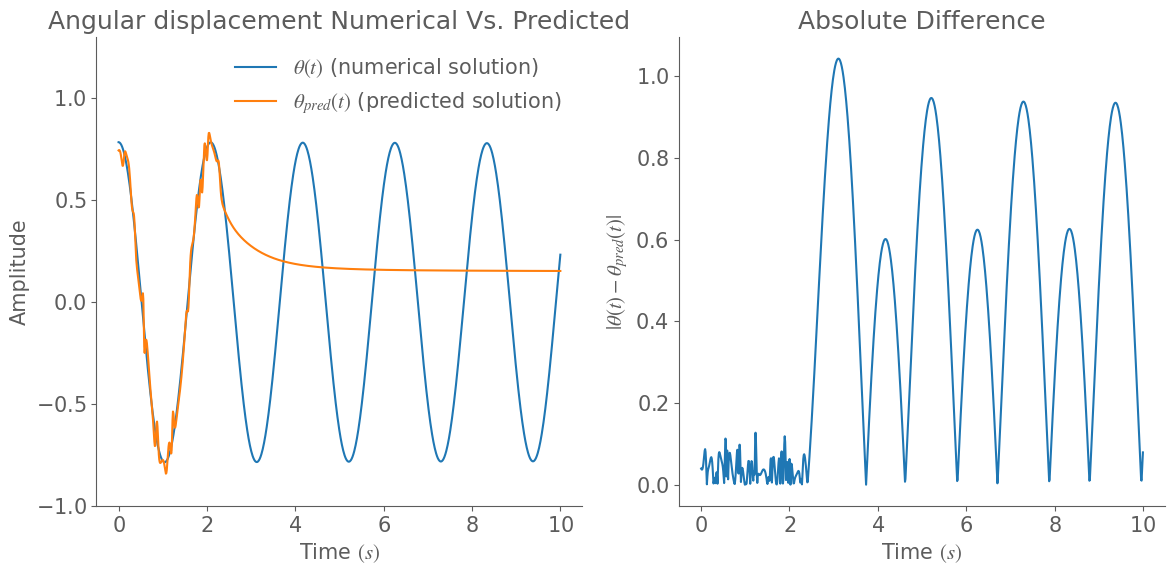

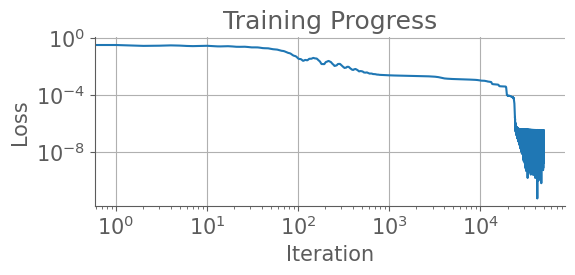

In [25]:
theta_pred_ann = theta_ann(t_test).to(device)

print(f'Relative error: {relative_l2_error(theta_pred_ann, theta_test)}')

plot_comparison(t_test, theta_num, theta_pred_ann, loss_values_ann)

## 4. Entrenando la Red Neuronal Informada por Física (PINN)

Ahora queremos entrenar una PINN de para aproximar la solución de la EDO,

$$
\theta_{PINN}(t; \Theta) \approx \theta(t).
$$

Esta PINN tendrá la misma arquitectura que la ANN que usamos anteriormente, pero esta vez la entrenaremos incorporando la física del problema además de las observaciones. Usaremos las mismas observaciones ruidosas (**datos de entrenamiento**) que antes, pero también incluiremos las ecuaciones que describen el comportamiento de las derivadas de la solución.

In [26]:
# Create an instance of the neural network
theta_pinn = NeuralNetwork(hidden_layers).to(device)
nparams = sum(p.numel() for p in theta_pinn.parameters() if p.requires_grad)
print(f'Number of trainable parameters: {nparams}')

# Define an optimizer (Adam) for training the network
optimizer = optim.Adam(theta_pinn.parameters(), lr=learning_rate,
                       betas= (0.99,0.999), eps = 1e-8)

Number of trainable parameters: 5251


### Diferenciación automática en PyTorch 

Antes de continuar será útil aprender a calcular las derivadas de una red neuronal. Para esto utilizaremos la diferenciación automática (*autodiff*), que es una técnica para calcular gradientes de funciones de forma eficiente y precisa mediante el uso de la regla de la cadena. PyTorch registra la forma en que operamos las variables en un gráfico computacional dinámico, que luego le permite calcular derivadas automáticamente al realizar una "propagación hacia atrás" (*backpropagation*). 

In [27]:
# Definir tensor de entrada. Si queremos derivar c/r a x necesitamos inicializar con requires_grad=True
x = torch.tensor([1.0, 2.0, 3.0], device=device, requires_grad=True).view(-1,1).float() # (N,1)

# Calcular operación que dependen de x
y = x**2 # (N,1)  

# Calcular derivadas c/r a x 
# grad es un wrapper de torch.autograd
dy_dx = grad(y, x) 

# Calcular derivadas de orden superior
d2y_dx2 = grad(dy_dx, x)  

print("x:", x)
print("y = x^2:", y)
print("dy/dx:", dy_dx)
print("d^2y/dx^2:", d2y_dx2)  

# Esto también funciona para redes neuronales
NNx = theta_pinn(x)
dNNx_dx = grad(NNx, x)
print("NNx: ", dNNx_dx)
print("dNNx/dx:", dNNx_dx)

x: tensor([[1.],
        [2.],
        [3.]], device='cuda:0', grad_fn=<ViewBackward0>)
y = x^2: tensor([[1.],
        [4.],
        [9.]], device='cuda:0', grad_fn=<PowBackward0>)
dy/dx: tensor([[2.],
        [4.],
        [6.]], device='cuda:0', grad_fn=<MulBackward0>)
d^2y/dx^2: tensor([[2.],
        [2.],
        [2.]], device='cuda:0', grad_fn=<MulBackward0>)
NNx:  tensor([[0.0109],
        [0.0500],
        [0.0694]], device='cuda:0', grad_fn=<MmBackward0>)
dNNx/dx: tensor([[0.0109],
        [0.0500],
        [0.0694]], device='cuda:0', grad_fn=<MmBackward0>)


### Función de pérdida informada por la física del problema

Para entrenar la PINN, recordemos el modelo del péndulo y definamos las funciones $f_{ode}(t;g,l)$, $g_{ic}(0)$ y $h_{bc}(0)$ para la ODE, la condición inicial y la condición de frontera. Además, reemplazamos la solución analítica $\theta(t)$ con la salida de la PINN $\theta_{pinn}(t; \Theta)$:

$$
\begin{align*}
f_{ode}(t;\theta_{pinn}):=&\frac{d^2\theta_{PINN}(t; \Theta)}{dt^2}+\frac{g}{l}\sin(\theta_{pinn}(t; \Theta)) = 0\\
g_{ic}(0;\theta_{pinn}):=&\theta_{pinn}(0; \Theta) = \theta_0\\
h_{bc}(0;\theta_{pinn}):=&\theta_{pinn}'(0; \Theta) = 0
\end{align*}
$$

Nuevamente utilizamos el $MSE$ y definimos la función de pérdida informada por física:

$$
\begin{align*}
\mathcal{L}(\theta):= &\frac{\lambda_1}{N}\sum_i\left(f_{ode}(t_i;\theta_{pinn})-0\right)^2 \quad \text{Pérdida de la ODE}\\
                   & + \lambda_2 (g_{ic}(0;\theta_{pinn})-\theta_0)^2 \quad \text{Pérdida de la condición inicial IC}\\
                   & + \lambda_3 (h_{bc}(0;\theta_{pinn})-0)^2 \quad \text{Pérdida de la condición de frontera BC}\\
                   & + \frac{\lambda_4}{N}\sum_i (\theta_{pinn}(t_i; \Theta) - \theta_{data}(t_i))^2 \quad \text{Pérdida de los datos (DATA)}
\end{align*}
$$

donde $\lambda_{1,2,3,4}\in\mathbb{R}^+$ son pesos positivos y $N$ es el número de muestras. 

<div class="alert alert-info"
    style="background-color:#5c5c5c;color:#000000;border-color:#000000">
  <strong>REMARK!</strong> Cuando no incluimos la función de pérdida relacionada con los datos, estamos empleando un esquema independiente de datos (*data-free*); cuando incluimos los datos, estamos empleando un esquema impulsado por datos (*data-driven*).
</div>

El entrenamiento se realiza minimizando la función de pérdida $\mathcal{L}(\Theta)$, es decir,

$$
\min_{\Theta\in\mathbb{R}} \mathcal{L}(\Theta)\rightarrow 0
$$

<div class="alert alert-info"
    style="background-color:#5c5c5c;color:#000000;border-color:#000000">
  <strong>REMARK!</strong> La diferenciación automática (`torch.autograd`) es una herramienta poderosa para calcular los gradientes de la PINN con respecto a la entrada, lo que será útil para evaluar la función de pérdida. 
</div>



In [28]:
# Define t = 0 for boundary an initial conditions
t0 = torch.tensor(0., device=device, requires_grad=True).view(-1,1)

# HINT: use grad funtion (a wraper for torch.autograd) to calculate the
# derivatives of the ANN
def PINNLoss(forward_pass, t_phys, t_data, theta_data, 
             lambda1 = 1, lambda2 = 1, lambda3 = 1, lambda4 = 1):

    # ANN output, first and second derivatives
    theta_pinn1 = forward_pass(t_phys)
    theta_pinn_dt = grad(theta_pinn1, t_phys)
    theta_pinn_ddt = grad(theta_pinn_dt, t_phys)
    
    f_ode = theta_pinn_ddt + (g/L) * torch.sin(theta_pinn1)
    ODE_loss = lambda1 * MSE_func(f_ode, torch.zeros_like(f_ode)) 
    
    g_ic = forward_pass(t0)
    IC_loss = lambda2 * MSE_func(g_ic, torch.ones_like(g_ic)*theta0)
    
    h_bc = grad(forward_pass(t0),t0)
    BC_loss = lambda3 * MSE_func(h_bc, torch.zeros_like(h_bc))
    
    theta_nn2 = forward_pass(t_data)
    data_loss = lambda4 * MSE_func(theta_nn2, theta_data)
    
    return ODE_loss + IC_loss + BC_loss + data_loss

# Initialize a list to store the loss values
loss_values_pinn = []

# Start the timer
start_time = time.time()

# Training the neural network
for i in range(training_iter):

    optimizer.zero_grad()   # clear gradients for next train

    # input x and predict based on x
    loss = PINNLoss(theta_pinn, t_test, t_data, theta_data)

    # Append the current loss value to the list
    loss_values_pinn.append(loss.item())

    if i % 1000 == 0:  # print every 100 iterations
        print(f"Iteration {i}: Loss {loss.item()}")

    loss.backward() # compute gradients (backpropagation)
    optimizer.step() # update the ANN weigths

# Stop the timer and calculate the elapsed time
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Training time: {elapsed_time} seconds")

Iteration 0: Loss 41.58959197998047
Iteration 1000: Loss 0.8080301284790039
Iteration 2000: Loss 0.5960748791694641
Iteration 3000: Loss 0.4157244563102722
Iteration 4000: Loss 0.32026273012161255
Iteration 5000: Loss 0.2804865539073944
Iteration 6000: Loss 0.21089571714401245
Iteration 7000: Loss 0.19753985106945038
Iteration 8000: Loss 0.17194625735282898
Iteration 9000: Loss 0.15166962146759033
Iteration 10000: Loss 0.12827114760875702
Iteration 11000: Loss 0.07939643412828445
Iteration 12000: Loss 0.012573368847370148
Iteration 13000: Loss 0.0028740977868437767
Iteration 14000: Loss 0.0025863093324005604
Iteration 15000: Loss 0.0023597741965204477
Iteration 16000: Loss 0.002339690225198865
Iteration 17000: Loss 0.0024333440233021975
Iteration 18000: Loss 0.0025661818217486143
Iteration 19000: Loss 0.0024373584892600775
Iteration 20000: Loss 0.0023634780663996935
Iteration 21000: Loss 0.0025270876940339804
Iteration 22000: Loss 0.0023373898584395647
Iteration 23000: Loss 0.002517514

Nuevamente, graficamos los resultados

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Relative error: 0.009387028403580189


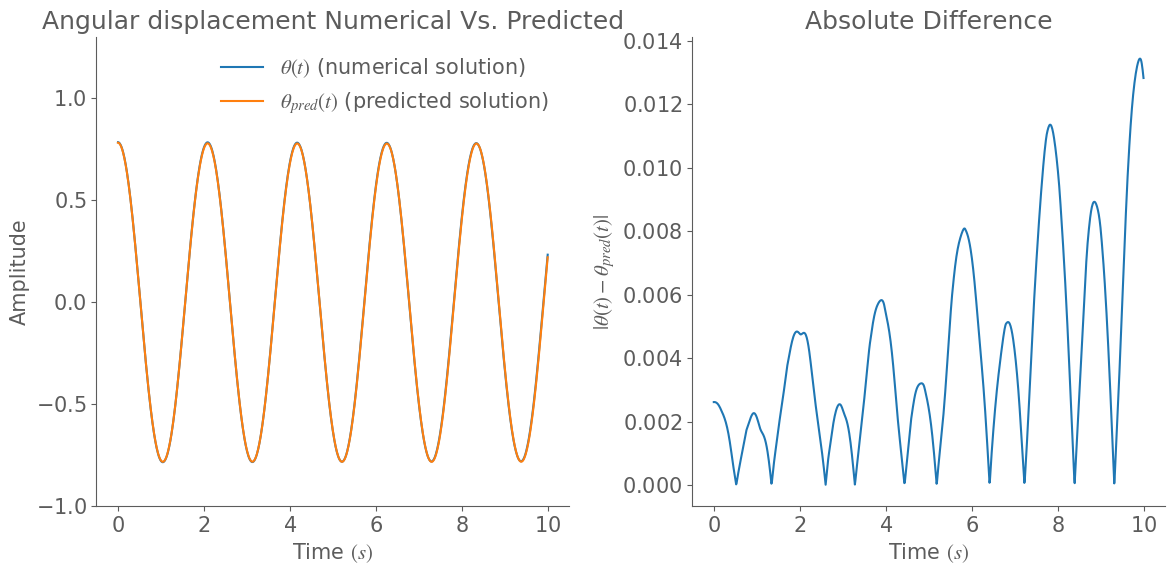

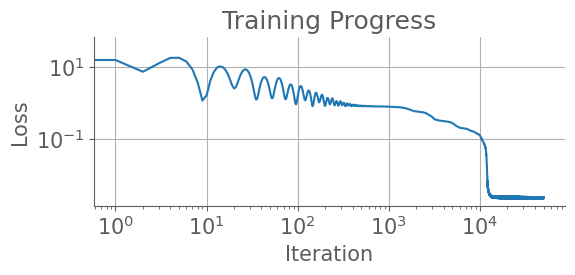

In [29]:
theta_pred_pinn = theta_pinn(t_test)

print(f'Relative error: {relative_l2_error(theta_pred_pinn, theta_test)}')

plot_comparison(t_test, theta_num, theta_pred_pinn, loss_values_pinn)

## 5. Comparación

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


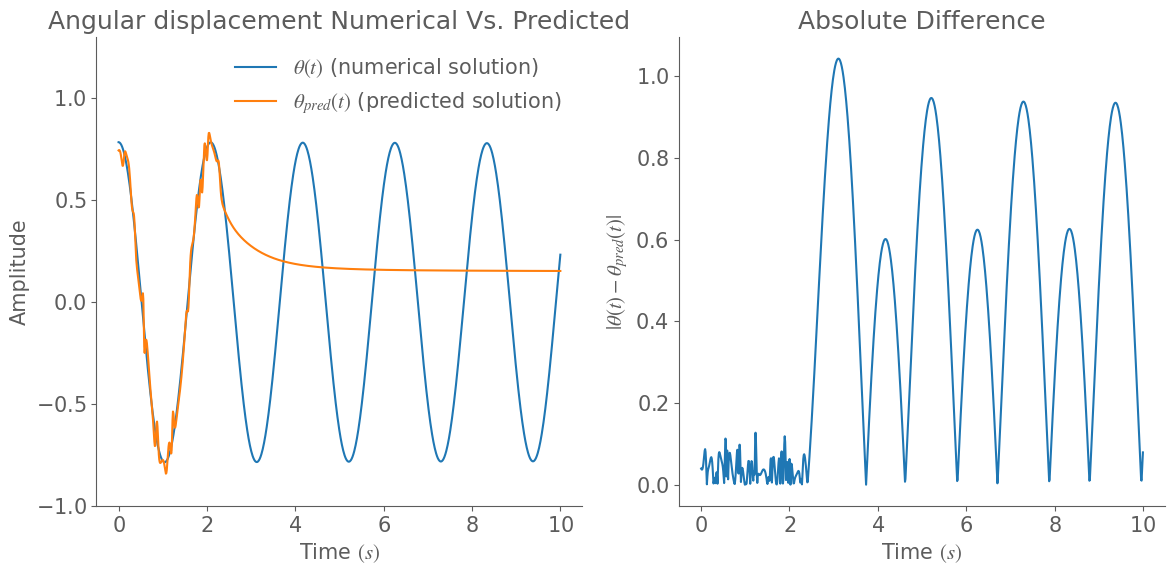

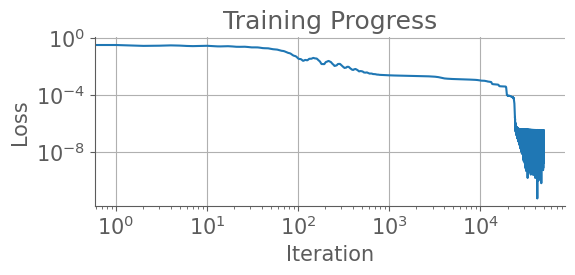

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


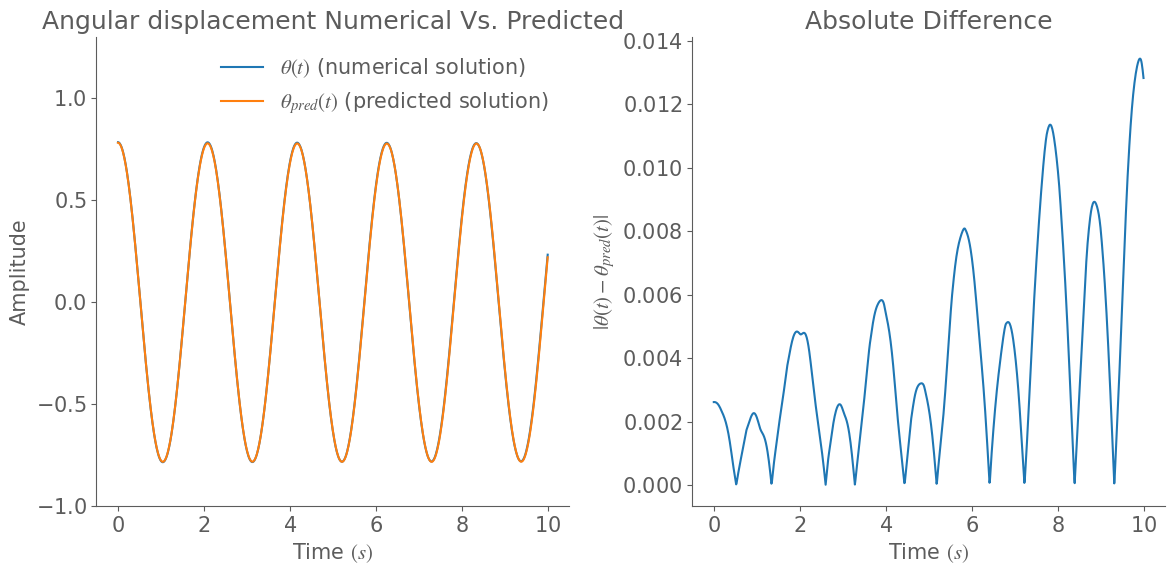

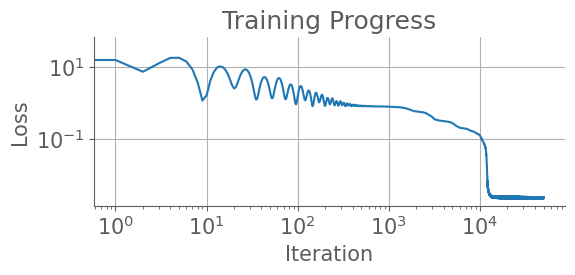

In [30]:
plot_comparison(t_test, theta_num, theta_pred_ann, loss_values_ann)
plot_comparison(t_test, theta_num, theta_pred_pinn, loss_values_pinn)

## **Ejercicios**:

1. Elimina la pérdida de los datos del entrenamiento de la PINN. ¿Aún se puede obtener la solución?
2. Incrementa y reduce el parámetro `std_deviation` en la sección [Preparación de los datos de entrenamiento](#data_prep) para cambiar el `SNR`. También cambia las variables `resample` y `ctime`, y compara los resultados tras entrenar la ANN y la PINN.
3. Ajusta los valores de los parámetros `lambdas` en la función de pérdida para ambas redes y analiza su impacto.
4. Modifica la tasa de aprendizaje (`learning_rate`) del optimizador y el número de iteraciones de entrenamiento, y evalúa el efecto en el desempeño.
5. Cambia el número de capas ocultas (`hidden_layers`), neuronas y funciones de activación de la red neuronal, y observa el impacto en los resultados.

## **Preguntas**:

1. **¿Cómo se puede abordar el sobreajuste en las PINNs si el objetivo es aprender los operadores subyacentes del sistema físico?**  
   <details>
   <summary>Respuesta</summary>
   El sobreajuste en las PINNs (Physics-Informed Neural Networks) es un tema ampliamente discutido. En el aprendizaje automático tradicional, el sobreajuste se asocia con la incapacidad de un modelo para generalizar a datos no vistos previamente, lo que afecta su capacidad para realizar predicciones precisas en nuevas entradas. Sin embargo, en el contexto de las PINNs, buscamos un comportamiento diferente: que la red neuronal funcione como un modelo surrogate de la solución de las ecuaciones diferenciales que describen el sistema físico. En este caso, el sobreajuste no necesariamente es perjudicial, ya que queremos que la red reproduzca fielmente la solución dentro del dominio especificado.

   El desafío relacionado con la generalización en las PINNs surge cuando estas redes se evalúan en geometrías más complejas o diferentes de las que fueron utilizadas durante el entrenamiento. En tales casos, una PINN que esté sobreajustada a una única geometría podría fallar al adaptarse a las nuevas configuraciones, comprometiendo su capacidad para generalizar y capturar las dinámicas físicas subyacentes en contextos más diversos. Por ello, abordar el sobreajuste implica equilibrar la fidelidad al dominio original y la adaptabilidad a nuevas geometrías o condiciones.
   </details>


2. **Qué ventajas ofrece el uso del MSE en la función de pérdida, dado que este enfoque puede subestimar la solución al no incorporar formulaciones integrales o variacionales**  
   <details>
   <summary>Respuesta</summary>
   El uso del MSE como función de pérdida proporciona una forma sencilla y computacionalmente eficiente de medir las diferencias puntuales entre las predicciones del modelo y los valores objetivo. Sin embargo, el MSE se centra únicamente en puntos individuales, lo que puede limitar su capacidad para capturar el comportamiento global de la solución, especialmente en dominios complejos. Al incorporar formulaciones integrales o variacionales, la función de pérdida puede reflejar el comportamiento de la solución en todo el dominio, mejorando potencialmente la precisión y estabilidad. A pesar de estas limitaciones, el MSE sigue siendo popular porque simplifica la implementación y reduce los costos computacionales, lo que lo hace adecuado para muchas aplicaciones prácticas.
   </details>


3. **¿En qué formas son ventajosas las PINNs comparadas con los métodos numéricos tradicionales, considerando el mayor tiempo requerido para el entrenamiento?**  
   <details>
   <summary>Respuesta</summary>
   Las PINNs ofrecen varias ventajas frente a los métodos numéricos tradicionales, a pesar de su tiempo de entrenamiento generalmente más largo. Una ventaja clave es su flexibilidad para manejar dominios complejos, de alta dimensionalidad y geometrías irregulares sin requerir mallas estructuradas. Las PINNs también pueden incorporar fácilmente restricciones o datos adicionales, como mediciones experimentales o condiciones de frontera. A diferencia de muchos métodos numéricos, una vez entrenadas, las PINNs generalizan bien a diferentes condiciones iniciales y de frontera, lo que puede hacerlas más versátiles en escenarios que requieren simulaciones repetidas o ajustes de parámetros. Esta flexibilidad y adaptabilidad las convierten en una herramienta poderosa para ciertas tareas de modelado informadas por física donde los métodos tradicionales pueden estar limitados.
   </details>
